In [290]:
import soundfile as sf
from pydub import AudioSegment
import pandas as pd
import os
import textgrid
import tqdm
import matplotlib.pyplot as plt
import numpy as np


from phonecodes import phonecodes
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from torch.nn import Transformer
from torch import Tensor
from sklearn.model_selection import train_test_split
import copy
import tqdm
import librosa
import seaborn as sns
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import textgrid
from scipy.spatial.distance import euclidean
import plotly.graph_objects as go
import pandas as pd
import jiwer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import nltk
nltk.download('cmudict')
from nltk.corpus import cmudict
from transformers import AutoProcessor, AutoModelForCTC
from phonemizer.backend.espeak.wrapper import EspeakWrapper
import soundfile as sf

_ESPEAK_LIBRARY = r"C:\Program Files\eSpeak NG\libespeak-ng.dll"
EspeakWrapper.set_library(_ESPEAK_LIBRARY)
processor_P = AutoProcessor.from_pretrained("facebook/wav2vec2-lv-60-espeak-cv-ft")
model_P = AutoModelForCTC.from_pretrained("facebook/wav2vec2-lv-60-espeak-cv-ft")

from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

[nltk_data] Downloading package cmudict to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


c:\Users\Alex\anaconda3\envs\BayesPCN\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at facebook/wav2vec2-lv-60-espeak-cv-ft were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights 

In [ ]:
arpabet_to_ipa={
    '<pad>': '<pad>',
    '<unk>': '<unk>',
    '<s>': '<s>',
    '</s>': '</s>',
    'AA0': 'ɑ',
    'AA1': 'ɑ',#ː
    'AA2': 'ɑ',
    'AE0': 'æ',
    'AE1': 'æ',
    'AE2': 'æ',
    'AH0': 'ə',
    'AH1': 'ʌ',
    'AH2': 'ʌ',
    'AO0': 'ɔ',
    'AO1': 'ɔ',#ː
    'AO2': 'ɔ',
    'AW0': 'aʊ',
    'AW1': 'aʊ',
    'AW2': 'aʊ',
    'AY0': 'aɪ',
    'AY1': 'aɪ',
    'AY2': 'aɪ',
    'B': 'b',
    'CH': 'tʃ',
    'D': 'd',
    'DH': 'ð',
    'EH0': 'ɛ',
    'EH1': 'ɛ',
    'EH2': 'ɛ',
    'ER0': 'ɚ',
    'ER1': 'ɚ',
    'ER2': 'ɚ',
    'EY0': 'eɪ',
    'EY1': 'eɪ',
    'EY2': 'eɪ',
    'F': 'f',
    'G': 'ɡ',
    'HH': 'h',
    'IH0': 'ɪ',
    'IH1': 'ɪ',
    'IH2': 'ɪ',
    'IY0': 'i',
    'IY1': 'i',#ː
    'IY2': 'i',
    'JH': 'dʒ',
    'K': 'k',
    'L': 'l',
    'M': 'm',
    'N': 'n',
    'NG': 'ŋ',
    'OW0': 'oʊ',
    'OW1': 'oʊ',
    'OW2': 'oʊ',
    'OY0': 'ɔɪ',
    'OY1': 'ɔɪ',
    'OY2': 'ɔɪ',
    'P': 'p',
    'R': 'ɹ',
    'S': 's',
    'SH': 'ʃ',
    'T': 't',
    'TH': 'θ',
    'UH0': 'ʊ',
    'UH1': 'ʊ',
    'UH2': 'ʊ',
#    'UW': 'uː',
    'UW0': 'u',
    'UW1': 'u',#ː
    'UW2': 'u',
    'V': 'v',
    'W': 'w',
    'Y': 'j',
    'Z': 'z',
    'ZH': 'ʒ',
}

In [2]:
human_result_path=r"..\data\test.xlsx"
human_result = pd.read_excel(human_result_path)
human_result_1a=human_result[human_result["Experiment"]=="1a"]

In [39]:
talkersets=list(set([j for i in set(human_result_1a["TrainingTalkerID"]) for j in i.split(", ")]))

In [33]:
set1_list=[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16]
set2_list=[17,18,19,20,21,22,24,25,26,27,28,29,30,31,37,40]

In [35]:
def get_training_paths(TrainingTalkerID,all_path):
    path_list=[]
    TalkerID=[]
    for each_ID in TrainingTalkerID.split(", "):
        if each_ID[:3]=="CMN":
            TalkerID.append(f"ALL_{each_ID[-3:]}_M_CMN_ENG_HT1")
        else:
            TalkerID.append(f"ALL_{each_ID[-3:]}_M_ENG_ENG_HT1")
    
    for each_path in TalkerID:
        for i in all_path:
            if each_path in i:
                path_list.append(i)
                break
    return path_list
def get_pathset(paths):
    return [os.path.join(dir, each_file) for dir, mid, files in os.walk(paths) for each_file in files if each_file.endswith(".wav")]


In [81]:
keyword_loc=human_result_1a.columns.get_loc("Keyword")
sentenceID=human_result_1a.columns.get_loc("Sentence")
sentence_keyword={}
for each_ in tqdm.tqdm(human_result_1a.values):
    sentence_name=each_[sentenceID][:-1].lower()
    if sentence_name not in sentence_keyword.keys():
        sentence_keyword[sentence_name]=[]
    if each_[keyword_loc] not in sentence_keyword[sentence_name]:
        sentence_keyword[sentence_name].append(each_[keyword_loc])

100%|██████████| 16477/16477 [00:00<00:00, 1568034.37it/s]


In [97]:
sentence_keyword

{'the shoes were very dirty': ['shoes', 'were', 'very', 'dirty'],
 'the wife helped her husband': ['wife', 'helped', 'husband'],
 'the bananas are too ripe': ['bananas', 'are', 'too', 'ripe'],
 'the car is going too fast': ['car', 'going', 'too', 'fast'],
 'big dogs can be dangerous': ['big', 'dogs', 'be', 'dangerous'],
 'he grew lots of vegetables': ['grew', 'lots', 'vegetables'],
 'she argues with her sister': ['argues', 'sister'],
 'the family likes fish': ['family', 'likes', 'fish'],
 'the player lost a shoe': ['player', 'lost', 'shoe'],
 'the kitchen window was clean': ['kitchen', 'window', 'was', 'clean'],
 'the picture came from a book': ['picture', 'came', 'book'],
 "she's drinking from her own cup": ['drinking', 'own', 'cup'],
 'somebody stole the money': ['somebody', 'stole', 'money'],
 'the paint dripped on the ground': ['paint', 'dripped', 'ground'],
 'a boy fell from the window': ['boy', 'fell', 'window'],
 'the fire was very hot': ['fire', 'very', 'hot'],
 "it's time to g

In [253]:


#sentence_keyword[sentence_name]


def get_phoneme(tg):
    tg_sentence = [i for i in tg[0] if i.mark!=""]
    tg_word = [i for i in tg[1] if i.mark!="" and i.mark!="sp"]
    phoneme_list=[]
    for x in set_list:
        for each_word_tg in tg_word:
            if tg_sentence[x].mark.lower() =='a boy fell from a window':
                sentence_name='a boy fell from the window'
            else:
                sentence_name=tg_sentence[x].mark.lower()
            key_word=sentence_keyword[sentence_name]
            #print(key_word)
            for each_key in key_word:
                if each_word_tg.minTime >= tg_sentence[x].minTime and each_word_tg.maxTime <= tg_sentence[x].maxTime:
                    if each_word_tg.mark.lower()==each_key:
                        phoneme_list.append([[each_key,x]]+[i.mark for i in tg[-1] if each_word_tg.minTime<=i.minTime and each_word_tg.maxTime>=i.maxTime and i.mark!="" and i.mark!="sp" and i.mark!="sil"])
    return phoneme_list
                    


In [266]:
talkersets=sorted(talkersets)
talkersets

['CMN_M_016',
 'CMN_M_021',
 'CMN_M_032',
 'CMN_M_035',
 'CMN_M_037',
 'CMN_M_043',
 'ENG_M_055',
 'ENG_M_066',
 'ENG_M_070',
 'ENG_M_131',
 'ENG_M_133']

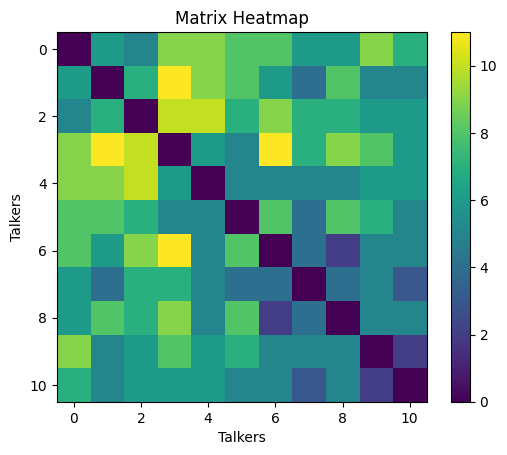

In [265]:
phoneme_diff_matrix=[]
for i in talkersets:
    taeget=get_phoneme(textgrid.TextGrid.fromFile(get_training_paths(i,all_path)[0][:-3]+"TextGrid"))
    each_phoneme_matrix=[]
    for j in talkersets:
        now=get_phoneme(textgrid.TextGrid.fromFile(get_training_paths(j,all_path)[0][:-3]+"TextGrid"))
        count=0
        for _,i in enumerate(now):
            if i != taeget[_]:
                count+=1
        each_phoneme_matrix.append(count)
    phoneme_diff_matrix.append(each_phoneme_matrix)

plt.imshow(phoneme_diff_matrix, cmap='viridis')  
plt.colorbar()  
plt.title("Matrix Heatmap") 
plt.xlabel("Talkers") 
plt.ylabel("Talkers") 
plt.show()  

In [280]:
talkersets

['CMN_M_016',
 'CMN_M_021',
 'CMN_M_032',
 'CMN_M_035',
 'CMN_M_037',
 'CMN_M_043',
 'ENG_M_055',
 'ENG_M_066',
 'ENG_M_070',
 'ENG_M_131',
 'ENG_M_133']

In [254]:
taeget=get_phoneme(textgrid.TextGrid.fromFile(get_training_paths(talkersets[0],all_path)[0][:-3]+"TextGrid"))
print(talkersets[0])
talker_new=talkersets[2]
print(talker_new)
new=get_phoneme(textgrid.TextGrid.fromFile(get_training_paths(talker_new,all_path)[0][:-3]+"TextGrid"))
for _,i in enumerate(new):
    if i != taeget[_]:
        print(i,taeget[_])
        

ENG_M_070
ENG_M_055
[['were', 3], 'W', 'ER0'] [['were', 3], 'W', 'ER1']
[['fire', 6], 'F', 'AY1', 'R'] [['fire', 6], 'F', 'AY1', 'ER0']


In [284]:
all_path = get_pathset(r"..\data\raw")
current_file=get_training_paths(talkersets[1],all_path)#change here
print(current_file)
speech=AudioSegment.from_wav(current_file[0])
tg = textgrid.TextGrid.fromFile(current_file[0][:-3]+"TextGrid")
tg_sentence_mark = [i.mark.lower() for i in tg[0] if i.mark!=""]
tg_sentence = [i for i in tg[0] if i.mark!=""]
set_list=set1_list+set2_list

['..\\data\\raw\\ALL_CMN_ENG_HT1\\ALL_021_M_CMN_ENG_HT1.wav']


In [286]:
#sentence_number
tg_sentence = [i for i in tg[0] if i.mark!=""]
tg_sentence=tg_sentence[set_list[4]]#change here
if tg_sentence.mark.lower() =='a boy fell from a window':
    sentence_name='a boy fell from the window'
else:
    sentence_name=tg_sentence.mark.lower()
sentence_keyword[sentence_name]

['player', 'lost', 'shoe']

In [287]:
print(current_file)
print(sentence_name)
key_word=sentence_keyword[sentence_name][0]
print(key_word)
tg_word = [i for i in tg[1] if i.mark!="" and i.mark!="sp"]
for each_word_tg in tg_word:
    if each_word_tg.minTime >= tg_sentence.minTime and each_word_tg.maxTime <= tg_sentence.maxTime:
        #print(each_word_tg.mark.lower(),key_word)
        #[arpabet_to_ipa[i.mark] for i in tg[-1] if each_word_tg.minTime<=i.minTime and each_word_tg.maxTime>=i.maxTime and i.mark!="" and i.mark!="sp" and i.mark!="sil"]
        if each_word_tg.mark.lower()==key_word:
            print([arpabet_to_ipa[i.mark] for i in tg[-1] if each_word_tg.minTime<=i.minTime and each_word_tg.maxTime>=i.maxTime and i.mark!="" and i.mark!="sp" and i.mark!="sil"])
            print([i.mark for i in tg[-1] if each_word_tg.minTime<=i.minTime and each_word_tg.maxTime>=i.maxTime and i.mark!="" and i.mark!="sp" and i.mark!="sil"])
            start=each_word_tg.minTime
            end=each_word_tg.maxTime
            break
tg_phonemes = [i for i in tg[-1] if i.mark!=""]
speech[start*1000:end*1000]

['..\\data\\raw\\ALL_CMN_ENG_HT1\\ALL_021_M_CMN_ENG_HT1.wav']
the player lost a shoe
player
['p', 'l', 'eɪ', 'ɚ']
['P', 'L', 'EY1', 'ER0']


In [297]:
print(current_file)
print(sentence_name)
key_word=sentence_keyword[sentence_name][1]
print(key_word)
tg_word = [i for i in tg[1] if i.mark!="" and i.mark!="sp"]
for each_word_tg in tg_word:
    if each_word_tg.minTime >= tg_sentence.minTime and each_word_tg.maxTime <= tg_sentence.maxTime:
        #print(each_word_tg.mark.lower(),key_word)
        #[arpabet_to_ipa[i.mark] for i in tg[-1] if each_word_tg.minTime<=i.minTime and each_word_tg.maxTime>=i.maxTime and i.mark!="" and i.mark!="sp" and i.mark!="sil"]
        if each_word_tg.mark.lower()==key_word:
            print([arpabet_to_ipa[i.mark] for i in tg[-1] if each_word_tg.minTime<=i.minTime and each_word_tg.maxTime>=i.maxTime and i.mark!="" and i.mark!="sp" and i.mark!="sil"])
            print([i.mark for i in tg[-1] if each_word_tg.minTime<=i.minTime and each_word_tg.maxTime>=i.maxTime and i.mark!="" and i.mark!="sp" and i.mark!="sil"])
            start=each_word_tg.minTime
            end=each_word_tg.maxTime
            break
tg_phonemes = [i for i in tg[-1] if i.mark!=""]
speech[start*1000:end*1000+1000]

['..\\data\\raw\\ALL_CMN_ENG_HT1\\ALL_021_M_CMN_ENG_HT1.wav']
the player lost a shoe
lost
['l', 'ɔ', 's', 't']
['L', 'AO1', 'S', 'T']


In [ ]:
english_phonemes = ['<pad>', '<unk>', '<s>', '</s>', 'ɑ', 'æ', 'ə', 'ʌ', 'ɔ', 'aʊ', 'aɪ', 'b', 'tʃ', 'd', 'ð', 'ɛ', 'ɚ', 'eɪ', 'f',
 'ɡ', 'h', 'ɪ', 'i', 'dʒ', 'k', 'l', 'm', 'n', 'ŋ', 'oʊ', 'ɔɪ', 'p', 'ɹ', 's', 'ʃ', 't', 'θ', 'ʊ', 'u', 'v', 'w', 'j', 'z', 'ʒ']#['<pad>', '<s>', '</s>', '<unk>','p', 'b', 't', 'd', 'k', 'ɡ','m', 'n', 'ŋ', 'f', 'v', 'θ', 'ð', 's', 'z', 'ʃ', 'h', 'tʃ', 'dʒ', 'l', 'ɹ', 'w', 'j',"i","ɪ","ʊ","u","e","ɜ","æ","ʌ","ɑ","ɒ","eɪ","ɔɪ","oʊ","aɪ","aʊ"]
english_phoneme_dict = {k: v for k, v in processor_P.tokenizer.get_vocab().items() if k in english_phonemes}
wave, sr = librosa.load(current_file[0])
wave_res = librosa.resample(wave, orig_sr=sr, target_sr=16000)
start=round(tg_sentence.minTime*16000)
end=round(tg_sentence.maxTime*16000)
input=processor(wave_res[start:end],sampling_rate=16000, return_tensors="pt").input_values
input=input.to(device)
model_P.to(device)
with torch.no_grad():
    out_encoder1=model_P(input).logits
selected=out_encoder1
mask = np.ones(selected.shape[-1], dtype=bool)
mask[list(english_phoneme_dict.values())] = False
selected[:, :, mask] = 0
outind=torch.argmax(selected,dim=-1).cpu().numpy()
transcription = processor_P.batch_decode(outind)[0].split(" ")
transcription

['ð', 'ə', 'p', 'l', 'eɪ', 'ɚ', 'l', 'aʊ', 's', 'ə', 'ʃ', 'ɹ', 'ʊ']

In [201]:
print(current_file)
print(sentence_name)
key_word=sentence_keyword[sentence_name][2]
print(key_word)
tg_word = [i for i in tg[1] if i.mark!="" and i.mark!="sp"]
for each_word_tg in tg_word:
    if each_word_tg.minTime >= tg_sentence.minTime and each_word_tg.maxTime <= tg_sentence.maxTime:
        #print(each_word_tg.mark.lower(),key_word)
        #[arpabet_to_ipa[i.mark] for i in tg[-1] if each_word_tg.minTime<=i.minTime and each_word_tg.maxTime>=i.maxTime and i.mark!="" and i.mark!="sp" and i.mark!="sil"]
        if each_word_tg.mark.lower()==key_word:
            print([arpabet_to_ipa[i.mark] for i in tg[-1] if each_word_tg.minTime<=i.minTime and each_word_tg.maxTime>=i.maxTime and i.mark!="" and i.mark!="sp" and i.mark!="sil"])
            print([i.mark for i in tg[-1] if each_word_tg.minTime<=i.minTime and each_word_tg.maxTime>=i.maxTime and i.mark!="" and i.mark!="sp" and i.mark!="sil"])
            start=each_word_tg.minTime
            end=each_word_tg.maxTime
            break
tg_phonemes = [i for i in tg[-1] if i.mark!=""]
speech[start*1000:end*1000]

['..\\data\\raw\\ALL_CMN_ENG_HT1\\ALL_037_M_CMN_ENG_HT1.wav']
the shoes were very dirty
very
['v', 'ɛ', 'ɹ', 'i']
['V', 'EH1', 'R', 'IY0']


In [202]:
print(current_file)
print(sentence_name)
key_word=sentence_keyword[sentence_name][3]
print(key_word)
tg_word = [i for i in tg[1] if i.mark!="" and i.mark!="sp"]
for each_word_tg in tg_word:
    if each_word_tg.minTime >= tg_sentence.minTime and each_word_tg.maxTime <= tg_sentence.maxTime:
        if each_word_tg.mark.lower()==key_word:
            print([arpabet_to_ipa[i.mark] for i in tg[-1] if each_word_tg.minTime<=i.minTime and each_word_tg.maxTime>=i.maxTime and i.mark!="" and i.mark!="sp" and i.mark!="sil"])
            print([i.mark for i in tg[-1] if each_word_tg.minTime<=i.minTime and each_word_tg.maxTime>=i.maxTime and i.mark!="" and i.mark!="sp" and i.mark!="sil"])
            start=each_word_tg.minTime
            end=each_word_tg.maxTime
            break
tg_phonemes = [i for i in tg[-1] if i.mark!=""]
speech[start*1000:end*1000]

['..\\data\\raw\\ALL_CMN_ENG_HT1\\ALL_037_M_CMN_ENG_HT1.wav']
the shoes were very dirty
dirty
['d', 'ɚ', 't', 'i']
['D', 'ER1', 'T', 'IY0']


In [283]:
print(current_file)
print(sentence_name)
key_word=sentence_keyword[sentence_name][1]
print(key_word)
tg_word = [i for i in tg[1] if i.mark!="" and i.mark!="sp"]
for each_word_tg in tg_word:
    if each_word_tg.minTime >= tg_sentence.minTime and each_word_tg.maxTime <= tg_sentence.maxTime:
        if each_word_tg.mark.lower()==key_word:
            print([arpabet_to_ipa[i.mark] for i in tg[-1] if each_word_tg.minTime<=i.minTime and each_word_tg.maxTime>=i.maxTime and i.mark!="" and i.mark!="sp" and i.mark!="sil"])
            print([i.mark for i in tg[-1] if each_word_tg.minTime<=i.minTime and each_word_tg.maxTime>=i.maxTime and i.mark!="" and i.mark!="sp" and i.mark!="sil"])
            start=each_word_tg.minTime
            end=each_word_tg.maxTime
            break
tg_phonemes = [i for i in tg[-1] if i.mark!=""]
speech[start*1000:end*1000]

['..\\data\\raw\\ALL_CMN_ENG_HT1\\ALL_016_M_CMN_ENG_HT1.wav']
the player lost a shoe
lost
['l', 'ɔ', 's', 't']
['L', 'AO1', 'S', 'T']
